5-Fold Cross-Validation Results:
 - Mean Squared Error (MSE): 8.94
 - R-squared (R²): 0.03


<ipython-input-1-6b7b9e6d8604>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_violations.index, x=top_violations.values, palette='pastel')


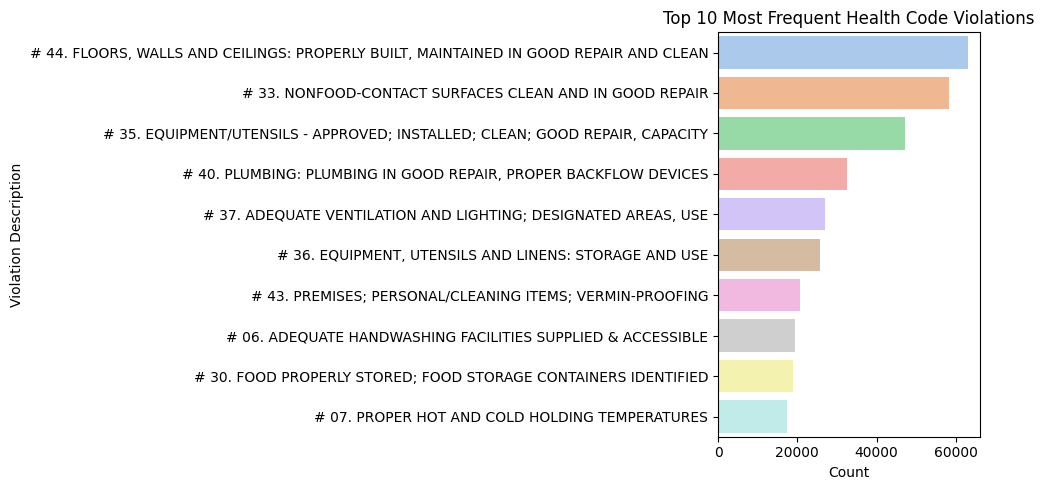

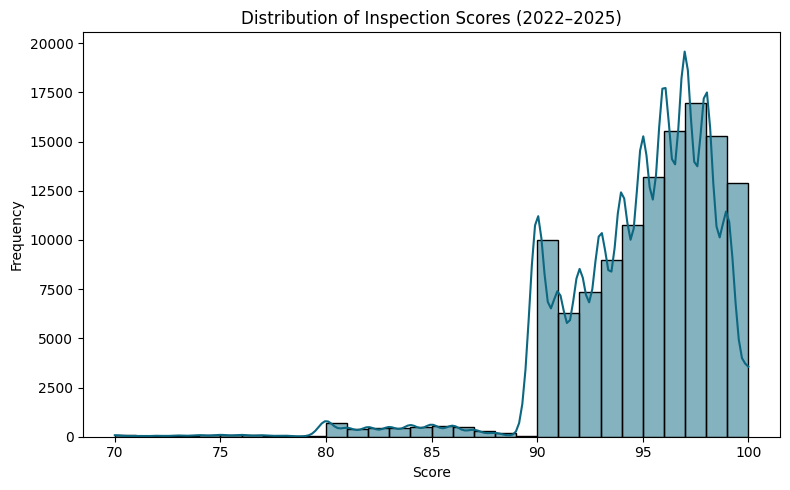

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score

df=pd.read_csv("health_inspections.csv", low_memory=False)
df['ACTIVITY DATE']=pd.to_datetime(df['ACTIVITY DATE'], errors='coerce')
df['SCORE']=pd.to_numeric(df['SCORE'], errors='coerce')
df['RATING']=pd.to_numeric(df['RATING'], errors='coerce')

violation_cols=[f'POINTS {i}' for i in range(23)]
df[violation_cols]=df[violation_cols].apply(pd.to_numeric, errors='coerce')
df['total_violation_points']=df[violation_cols].sum(axis=1)
df['violation_count']=df[violation_cols].notna().sum(axis=1)

df=df[df['ACTIVITY DATE'].dt.year.between(2022, 2025)]
df_train=df[df['ACTIVITY DATE'].dt.year <= 2024]
df_2025=df[df['ACTIVITY DATE'].dt.year == 2025]

agg_train=df_train.groupby('FACILITY NAME').agg({
    'SCORE': 'mean',
    'RATING': 'mean',
    'total_violation_points': 'mean',
    'violation_count': 'max'
}).reset_index()

agg_test=df_2025.groupby('FACILITY NAME').agg({'SCORE': 'mean'}).reset_index()
df_merged=pd.merge(agg_train, agg_test, on='FACILITY NAME', suffixes=('_past', '_2025')).dropna()

X=df_merged[['SCORE_past', 'RATING', 'total_violation_points', 'violation_count']]
y=df_merged['SCORE_2025']

model=RandomForestRegressor(n_estimators=100, random_state=42)
kf=KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv=cross_val_predict(model, X, y, cv=kf)
mse=mean_squared_error(y, y_pred_cv)
r2=r2_score(y, y_pred_cv)

print(f"5-Fold Cross-Validation Results:")
print(f" - Mean Squared Error (MSE): {mse:.2f}")
print(f" - R-squared (R²): {r2:.2f}")

violation_descriptions=[]
for i in range(23):
    col=f'VIOLATION DESCRIPTION {i}'
    if col in df:
        violation_descriptions += df[col].dropna().tolist()

violation_series=pd.Series(violation_descriptions)
top_violations=violation_series.value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(y=top_violations.index, x=top_violations.values, palette='pastel')
plt.title("Top 10 Most Frequent Health Code Violations")
plt.xlabel("Count")
plt.ylabel("Violation Description")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['SCORE'].dropna(), bins=30, kde=True, color='#0c6781')
plt.title("Distribution of Inspection Scores (2022–2025)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()